# Descriptive Stats Tests 1

## Goal plots
- bar graph of pla activity cycle
    - `dur_day_total_{activity cycle}_min_pla`
    - `dur_day_spt_min_pla`
    - calculate any missing time as unidentified
    - in part 5 person summary, or could do day summary by day


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
test_df_p5_person = pd.read_csv('/Volumes/vosslabhpc/Projects/BOOST/ObservationalStudy/3-experiment/data/act-obs-test/derivatives/GGIR-3.2.6-test/sub-7016/accel/output_accel/results/part5_personsummary_MM_L40M100V400_T5A5.csv')
test_df_p5_day = pd.read_csv('/Volumes/vosslabhpc/Projects/BOOST/ObservationalStudy/3-experiment/data/act-obs-test/derivatives/GGIR-3.2.6-test/sub-7016/accel/output_accel/results/part5_daysummary_MM_L40M100V400_T5A5.csv')

In [4]:
act_cycles = ['IN', 'LIG', 'MOD', 'VIG']

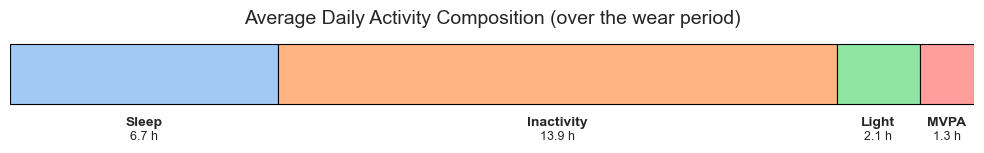

In [18]:
def plot_activity_cycle(df_person, act_cycles=['IN', 'LIG', 'MOD', 'VIG'], sleep_col='dur_spt_min_pla'):
    """
    Plots a horizontal stacked bar of daily activity composition:
    Sleep, Inactivity, Light activity, MVPA, and Unidentified time (if any).
    """
    # Collect durations
    durations = {cycle: df_person[f'dur_day_total_{cycle}_min_pla'].iloc[0] for cycle in act_cycles}
    mvpa = durations.pop('MOD') + durations.pop('VIG')
    durations = {
        'Sleep': df_person[sleep_col].iloc[0],
        'Inactivity': durations['IN'],
        'Light': durations['LIG'],
        'MVPA': mvpa
    }
    total_minutes = 24 * 60
    identified = sum(durations.values())
    unidentified = total_minutes - identified
    if unidentified > 0:
        durations['Unidentified'] = unidentified

    # Order of segments
    segments = ['Sleep', 'Inactivity', 'Light', 'MVPA']
    if 'Unidentified' in durations:
        segments.append('Unidentified')
    values = [durations[s] for s in segments]

    # Styling
    sns.set_theme(style='whitegrid', rc={'axes.facecolor': 'white'})
    fig, ax = plt.subplots(figsize=(10, 2))
    palette = sns.color_palette('pastel', n_colors=len(segments))

    left = 0
    min_width_for_inside_label = 40  # in minutes

    for seg, val, color in zip(segments, values, palette):
        bar_height = 0.4
        ax.barh(
            y=0,
            width=val,
            left=left,
            height=0.5,
            color=color,
            edgecolor='black',
            linewidth=0.8
        )
        center_x = left + val / 2

        if val >= min_width_for_inside_label:
            text_y = -bar_height / 2 - 0.15
        else:
            text_y = 0.6  # Move label above bar

        ax.text(
            center_x,
            text_y,
            seg,
            ha='center',
            va='bottom' if val < min_width_for_inside_label else 'top',
            fontsize=10,
            fontweight='bold'
        )
        ax.text(
            center_x,
            text_y + (0.12 if val < min_width_for_inside_label else -0.12),
            f"{val/60:.1f} h",
            ha='center',
            va='bottom' if val < min_width_for_inside_label else 'top',
            fontsize=9
        )

        left += val

    ax.set_xlim(0, total_minutes)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.grid(False)
    ax.set_title('Average Daily Activity Composition (over the wear period)', fontsize=14, pad=12)
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    plt.tight_layout()
    plt.show()
plot_activity_cycle(test_df_p5_person)

/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_24639/1122931281.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


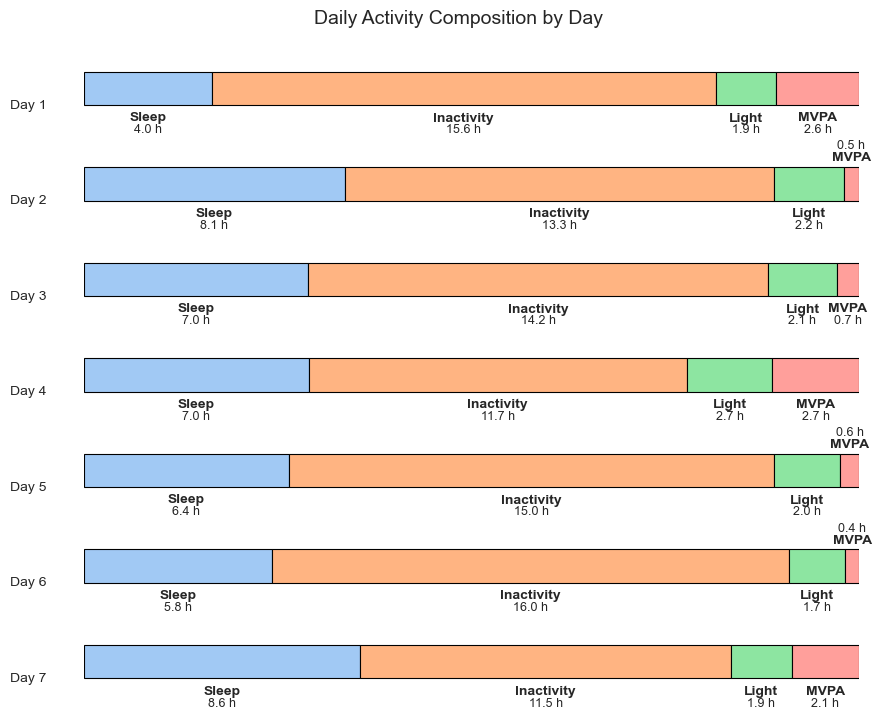

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_daily_activity_cycles(df_day,
                               act_cycles=['IN', 'LIG', 'MOD', 'VIG'],
                               sleep_col='dur_spt_min'):
    """
    Plots horizontal stacked bar charts for each day in df_day,
    with segment names and duration values centered beneath each stack.
    Expects columns:
      dur_day_total_IN_min, dur_day_total_LIG_min,
      dur_day_total_MOD_min, dur_day_total_VIG_min, dur_spt_min
    """
    n_days = len(df_day)
    total_minutes = 24 * 60

    # Use a tighter vertical spacing between subplots
    fig, axes = plt.subplots(
        n_days,
        1,
        figsize=(10, 1.2 * n_days),
        sharex=True,
        gridspec_kw={'hspace': 0.3}
    )
    if n_days == 1:
        axes = [axes]

    bar_height = 1.3
    for ax, (idx, row) in zip(axes, df_day.iterrows()):
        # Build durations for each segment
        durations = {
            'Sleep': row[sleep_col],
            'Inactivity': row['dur_day_total_IN_min'],
            'Light': row['dur_day_total_LIG_min'],
            'MVPA': row['dur_day_total_MOD_min'] + row['dur_day_total_VIG_min']
        }
        identified = sum(durations.values())
        unidentified = total_minutes - identified
        if unidentified > 1:
            durations['Unidentified'] = unidentified

        segments = list(durations.keys())
        values = [durations[s] for s in segments]
        palette = sns.color_palette('pastel', n_colors=len(segments))

        left = 0
        min_width_for_inside_label = 40  # in minutes

        for seg, val, color in zip(segments, values, palette):
            bar_height = 0.4
            ax.barh(
                y=0,
                width=val,
                left=left,
                height=0.5,
                color=color,
                edgecolor='black',
                linewidth=0.8
            )
            center_x = left + val / 2

            if val >= min_width_for_inside_label:
                text_y = -bar_height / 2 - 0.15
            else:
                text_y = 0.3  # Move label above bar

            ax.text(
                center_x,
                text_y,
                seg,
                ha='center',
                va='bottom' if val < min_width_for_inside_label else 'top',
                fontsize=10,
                fontweight='bold'
            )
            ax.text(
                center_x,
                text_y + (0.18 if val < min_width_for_inside_label else -0.18),
                f"{val/60:.1f} h",
                ha='center',
                va='bottom' if val < min_width_for_inside_label else 'top',
                fontsize=9
            )

            left += val

        # Hide y‐axis ticks and spines
        ax.set_yticks([])
        ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
        ax.grid(False)  # ← disables gridlines
        # Fix x‐axis limits
        ax.set_xlim(0, total_minutes)
        ax.set_xticks([])
        # Expand y‐limits to ensure space for labels beneath
        ax.set_ylim(-0.8, bar_height / 2 + 0.1)

        # Label each row with the day number on the left
        ax.set_ylabel(
            f"Day {int(idx) + 1}",
            rotation=0,
            labelpad=40,
            va='center',
            fontsize=10
        )

    # Label and title
    fig.suptitle('Daily Activity Composition by Day', fontsize=14, y=0.95)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_daily_activity_cycles(test_df_p5_day)

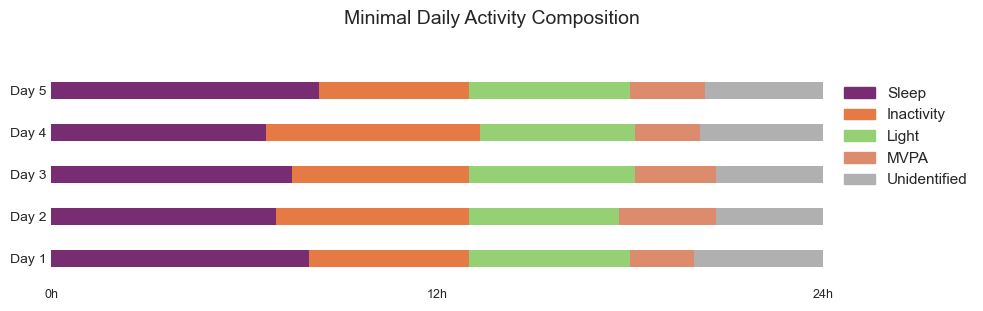

In [ ]:
# Sample data
data = {
    "Day": [f"Day {i+1}" for i in range(5)],
    "Sleep": [480, 420, 450, 400, 500],  # minutes
    "Inactivity": [300, 360, 330, 400, 280],
    "Light": [300, 280, 310, 290, 300],
    "MVPA": [120, 180, 150, 120, 140],
    "Unidentified": [240, 200, 240, 230, 220]  # Total = 1440
}

df = pd.DataFrame(data)

# Colors
colors = {
    "Sleep": "#782D73",         # Soft blue
    "Inactivity": "#E57A44",    # Neutral light gray
    "Light": "#95D075",         # Muted green
    "MVPA": "#DD8B6D",          # Soft coral red
    "Unidentified": "#B0B0B0"   # Medium gray
}
# Plot
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(10, 3))

bar_height = 0.4
y_positions = range(len(df))

for i, row in df.iterrows():
    left = 0
    for cat in ["Sleep", "Inactivity", "Light", "MVPA", "Unidentified"]:
        ax.barh(
            y=i,
            width=row[cat],
            left=left,
            height=bar_height,
            color=colors[cat],
            edgecolor='none'
        )
        left += row[cat]

# Day labels
ax.set_yticks(y_positions)
ax.set_yticklabels(df["Day"], fontsize=10)

# Clean up axes
ax.set_xticks([0, 720, 1440])
ax.set_xticklabels(["0h", "12h", "24h"], fontsize=9)
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
ax.tick_params(axis='y', length=0)
ax.set_xlim(0, 1440)

# Legend
handles = [plt.Rectangle((0,0),1,1, color=colors[key]) for key in colors]
labels = list(colors.keys())
ax.legend(handles, labels, bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

fig.suptitle("Minimal Daily Activity Composition", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

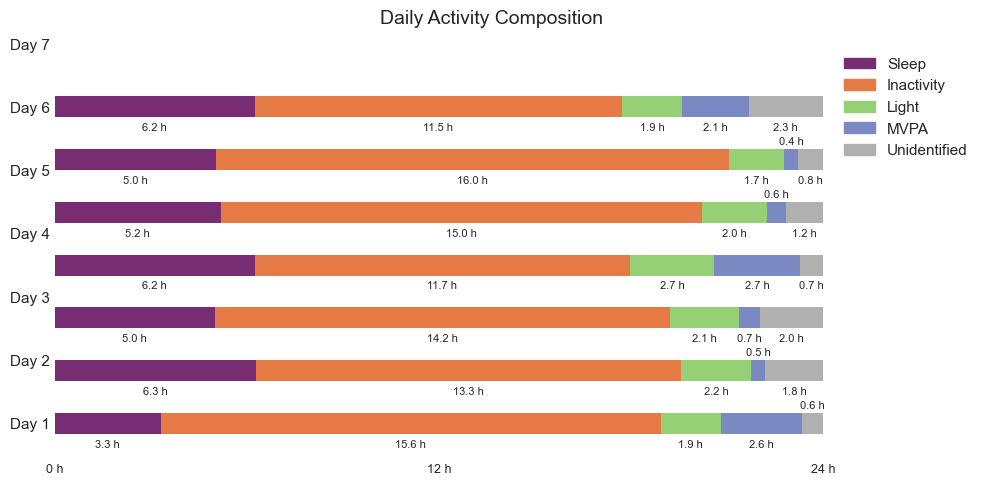

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_daily_activity_composition(
    df,
    sleep_col='dur_spt_sleep_min',
    act_cycles=('IN', 'LIG', 'MOD', 'VIG')
):
    """
    Plots a horizontal stacked bar of daily activity composition:
    Sleep, Inactivity, Light, MVPA, and Unidentified time.
    Also places the duration (in hours) beneath each segment.
    Expects columns:
      dur_day_total_IN_min, dur_day_total_LIG_min,
      dur_day_total_MOD_min, dur_day_total_VIG_min, dur_spt_min
      and a 'Day' column for labeling.
    """
    # Define colors
    colors = {
        "Sleep": "#782D73",         # Soft blue
        "Inactivity": "#E57A44",    # Neutral light gray
        "Light": "#95D075",         # Muted green
        "MVPA": "#7A89C2",          # Soft coral red
        "Unidentified": "#B0B0B0"   # Medium gray
    }

    sns.set_theme(style="white")
    total_minutes = 24 * 60
    bar_height = 0.4

    fig, ax = plt.subplots(figsize=(10, 3 + 0.3 * len(df)))
    y_spacing = 1.2
    y_positions = [i * y_spacing for i in range(len(df))]
    for i, row in df.iterrows():
        # Build durations
        durations = {
            'Sleep': row[sleep_col],
            'Inactivity': row['dur_day_total_IN_min'],
            'Light': row['dur_day_total_LIG_min'],
            'MVPA': row['dur_day_total_MOD_min'] + row['dur_day_total_VIG_min']
        }
        identified = sum(durations.values())
        unidentified = total_minutes - identified
        if unidentified > 0:
            durations['Unidentified'] = unidentified
        min_width_for_inside_label = 40  # minutes

        left = 0
        for cat, val in durations.items():
            ax.barh(
                y=i,
                width=val,
                left=left,
                height=bar_height,
                color=colors[cat],
                edgecolor='none'
            )

            center_x = left + val / 2
            if val >= min_width_for_inside_label:
                text_y = i - bar_height / 2 - 0.1
                va = 'top'
            else:
                text_y = i + bar_height / 2 + 0.05
                va = 'bottom'

            if val > 1:
                ax.text(
                    center_x,
                    text_y,
                    f"{val/60:.1f} h",
                    ha='center',
                    va=va,
                    fontsize=8
                )

            left += val
            # Set y-tick labels using Day column if available, else use Day 1, Day 2, ...
        
        y_labels = [f"Day {i+1}" for i in range(len(df))]


    # Day labels
    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels)

    # Clean up axes
    ax.set_xticks([0, total_minutes/2, total_minutes])
    ax.set_xticklabels(["0 h", "12 h", "24 h"], fontsize=9)
    ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
    ax.tick_params(axis='y', length=0)
    ax.set_xlim(0, total_minutes)

    # Legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[key]) for key in colors]
    labels = list(colors.keys())
    ax.legend(handles, labels, bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

    fig.suptitle("Daily Activity Composition", fontsize=14, y=0.95)
    plt.tight_layout()
    plt.show()

plot_daily_activity_composition(test_df_p5_day)